# DVD Inversion exercise (InSAR- Low Noise)

This notebook solves DVD inversion exercise using the InSAR datasets

## Import libraries

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Insar
from vmod.data import Joint
from vmod.source import Mctigue

## Read datasets

In [2]:
xsa,ysa,losa,azsa,incsa=np.loadtxt('examples/dvd/insar/Synth_Asc_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
xsd,ysd,losd,azsd,incsd=np.loadtxt('examples/dvd/insar/Synth_Des_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
azsa=np.radians(azsa)
azsd=np.radians(azsd)
incsa=np.radians(incsa)
incsd=np.radians(incsd)

In [3]:
nx=401
ny=nx
losaor=np.reshape(losa,(ny,nx))[:,::-1].T
losdor=np.reshape(losd,(ny,nx))[:,::-1].T
azsa=np.reshape(azsa,(ny,nx))[:,::-1].T
azsd=np.reshape(azsd,(ny,nx))[:,::-1].T
incsa=np.reshape(incsa,(ny,nx))[:,::-1].T
incsd=np.reshape(incsd,(ny,nx))[:,::-1].T

In [4]:
extenta=[np.min(xsa),np.max(xsa),np.min(ysa),np.max(ysa)]
extentd=[np.min(xsd),np.max(xsd),np.min(ysd),np.max(ysd)]
#util.mat2quad(losa,azsa,incsa,extenta,name='asc.txt',per=30,unit='m')
#util.mat2quad(losd,azsd,incsd,extentd,name='des.txt',per=30,unit='m')

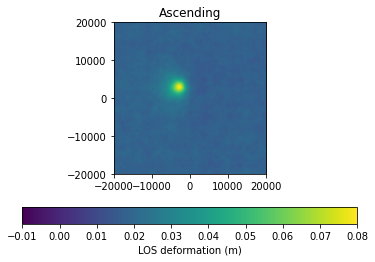

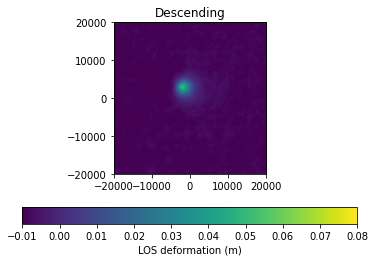

In [5]:
plt.figure()
plt.title('Ascending')
plt.imshow(losaor,extent=extenta,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.title('Descending')
plt.imshow(losdor,extent=extentd,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

In [6]:
util.quadtree_var(losaor,azsa,incsa,extent=[-20000,20000,-20000,20000],th=np.nanvar(losa)/200,name='examples/dvd/insar/asc_low.txt')
util.quadtree_var(losdor,azsd,incsd,extent=[-20000,20000,-20000,20000],th=np.nanvar(losd)/200,name='examples/dvd/insar/des_low.txt')

Final samples:  1996
Final samples:  1942


## Reading downsampled data

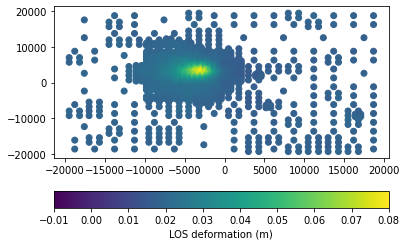

In [7]:
xsa,ysa,azsa,lksa,losa,elosa,refa=util.read_insar_csv('examples/dvd/insar/asc_low.txt',cref=False)

plt.figure()
plt.scatter(xsa,ysa,c=losa,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

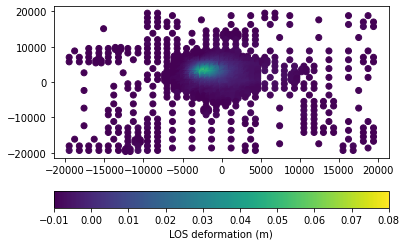

In [8]:
xsd,ysd,azsd,lksd,losd,elosd,refd=util.read_insar_csv('examples/dvd/insar/des_low.txt',cref=False)

plt.figure()
plt.scatter(xsd,ysd,c=losd,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Create data object

In [9]:
obsa=Insar()
obsa.add_xs(xsa)
obsa.add_ys(ysa)
obsa.add_vecs(azsa,lksa)
obsa.add_los(losa)
obsa.add_err(elosa)

obsd=Insar()
obsd.add_xs(xsd)
obsd.add_ys(ysd)
obsd.add_vecs(azsd,lksd)
obsd.add_los(losd)
obsd.add_err(elosd)

obs=Joint()
obs.add_dataset(obsa)
obs.add_dataset(obsd)

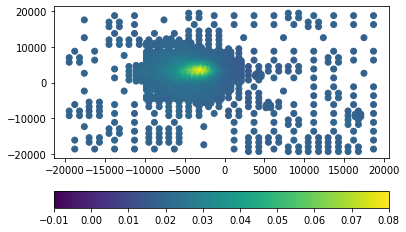

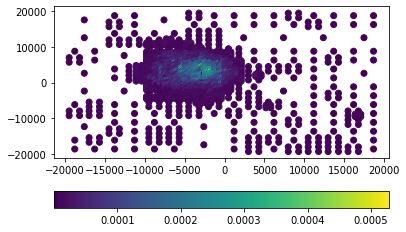

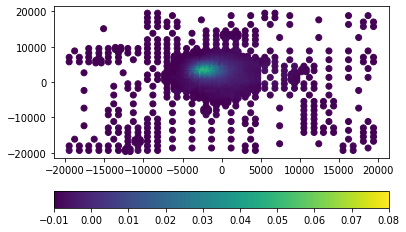

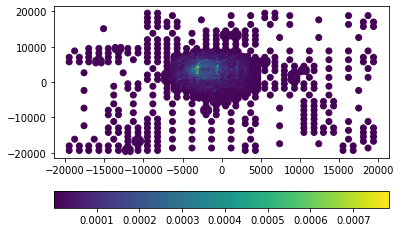

In [10]:
plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=elosa)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=elosd)
plt.colorbar(orientation='horizontal')

## Create model objects for each direction

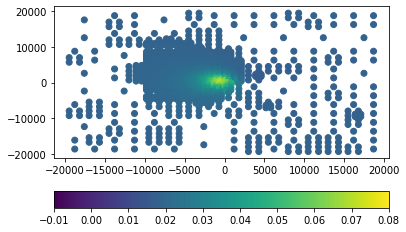

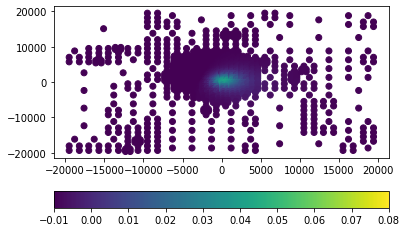

In [11]:
mcta=Mctigue(obsa)
mcta.add_offsets()
losm=mcta.forward([0,0,2.0e3,5e2,1e6,0.018])

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctd=Mctigue(obsd)
mctd.add_offsets()
losm=mctd.forward([0,0,2.0e3,5e2,1e6,-0.01])

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Create object model for joint data

In [12]:
mct=Mctigue(obs)
mct.add_offsets()
mct.set_x0([0,0,2e3,5e2,1e6,0.01,-0.01])
#Bounds for parameters
mct.set_bounds(low_bounds = [-20000,-20000,1e2,1e2,1e5,0,-0.1], high_bounds = [20000,20000,9e4,5e3,1e8,0.1,0])

## Create Inversion object

In [13]:
from vmod.inverse import Inverse

inv=Inverse(obs)
inv.register_source(mct)

## Least squares inversion

In [14]:
ans=inv.nlsq()

print(ans.x)

0.002112199448992533
[-2.54479319e+03  2.84925227e+03  2.01555623e+03  3.91066718e+02
  1.20343798e+06  1.81373913e-02 -9.69087695e-03]


[-2.54479319e+03  2.84925227e+03  2.01555623e+03  3.91066718e+02
  1.20343798e+06  1.81373913e-02] [-2.54479319e+03  2.84925227e+03  2.01555623e+03  3.91066718e+02
  1.20343798e+06 -9.69087695e-03]


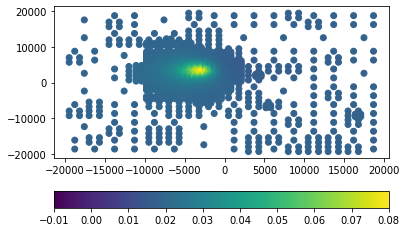

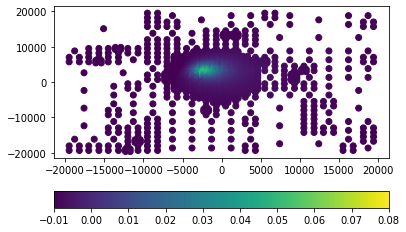

In [15]:
ansa=ans.x[0:len(ans.x)-1]
ansd=np.concatenate((ans.x[0:len(ans.x)-2],[ans.x[-1]]))
print(ansa,ansd)
losm=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

losm=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Bayesian inversion

In [16]:
#trace,MDL=inv.mcmc('insar_low')

In [17]:
import pickle
#with open('unimak_gnss_3s.pkl','rb') as handle:
with open('insar_low.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

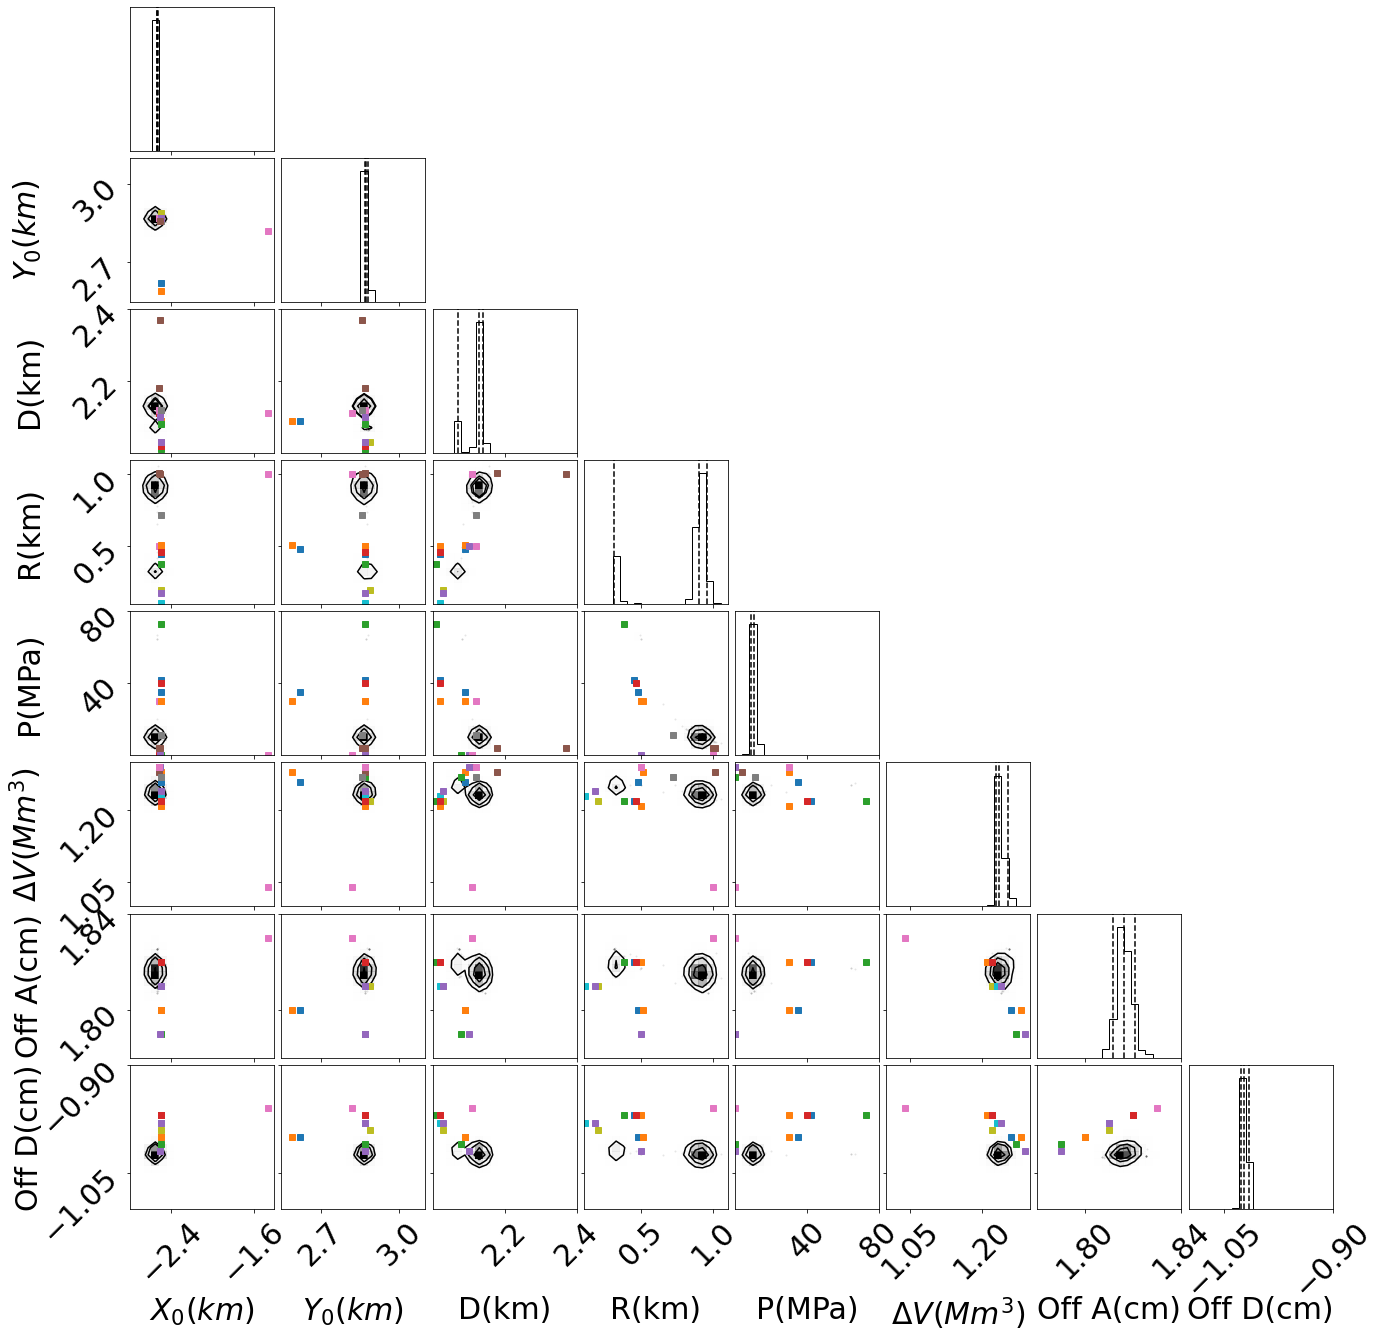

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
newdata[4,:]=np.copy(data[4,:]*2e10/(np.pi*data[3,:]**3))
newdata[5::,:]=np.copy(data[4::,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
data[6,:]=data[6,:]*1e2
data[7,:]=data[7,:]*1e2
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$','Off A(cm)','Off D(cm)']

trus1=[-2.50,2.62,2.09,0.48,35,1.26,1.80,-1.00]
trus2=[-2.50,2.59,2.09,0.51,30,1.28,1.80,-1.00]
trus3=[-2.50,2.87,2.08,0,0,1.27,1.79,-1.01]
trus4=[-2.52,2.87,2.11,0,0,1.29,0,0]
trus5=[-2.51,2.87,2.10,0.5,0,1.29,1.79,-1.02]
trus6=[-2.52,2.87,2.18,1.01,4,1.28,0,0]
trus7=[-2.52,2.87,2.12,0.50,30,1.29,0,0]
trus8=[-2.50,2.86,2.12,0.72,11,1.27,0,0]
trus9=[-2.50,2.89,2.03,0.20,484,1.22,1.81,-0.99]
trus10=[-2.50,2.87,2.02,0.11,3340,1.23,1.81,-0.98]
trus11=[-2.50,2.87,2.02,0.45,42,1.22,1.82,-0.97]
trus12=[-2.50,2.87,2.02,0.50,30,1.21,1.82,-0.97]
trus13=[-2.50,2.87,2.01,0.38,73,1.22,1.82,-0.97]
trus14=[-2.50,2.87,2.02,0.46,40,1.22,1.82,-0.97]
trus15=[-2.50,2.87,2.03,0.18,710,1.24,1.81,-0.98]
trus16=[-2.51,2.86,2.37,1.00,4,0,0,0]
trus17=[-1.46,2.82,2.11,1.00,0,1.04,1.83,-0.96]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10,trus11,trus12,trus13,trus14,trus15,trus16,trus17]

ranges=[(-2.8,-1.40),(2.55,3.1),(2.0,2.4),(0.1,1.1),(0,80),(1.0,1.3),(1.78,1.84),(-1.1,-0.9)]

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,range=ranges,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

for i,tru in enumerate(trus):
    #corner.overplot_lines(figure, np.array(tru), color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')

plt.savefig('histograms')

## Calculation of percentiles to upload the results

In [19]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

results=[means,lower95,upper95,lower32,upper68]

for res in results:
    for i in range(len(res)):
        if i in [0,1,2,3]:
            res[i]=res[i]*1e3
        elif i in [4,5]:
            res[i]=res[i]*1e6
        elif i in [6,7]:
            res[i]=res[i]/1e2
    print("%4.0f,%4.0f,%4.0f,%3.0f,%2.0f,%2.0f,%1.5f,%1.5f"%(tuple(res)))

-2536,2874,2130,904,10649375,1235995,0.01816,-0.01022
-2540,2871,2070,311,8958012,1229593,0.01811,-0.01027
-2533,2881,2140,957,263885950,1254696,0.01821,-0.01016
-2537,2873,2125,882,10019023,1233831,0.01815,-0.01023
-2535,2876,2133,922,11437045,1239211,0.01818,-0.01021


[-2.53626601e+03  2.87431210e+03  2.12982425e+03  9.04030398e+02
  1.23599515e+06  1.81592912e-02] [-2.53626601e+03  2.87431210e+03  2.12982425e+03  9.04030398e+02
  1.23599515e+06 -1.02224620e-02]


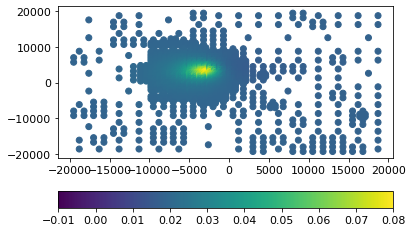

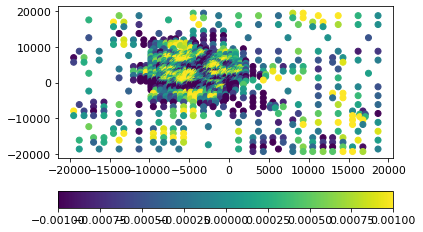

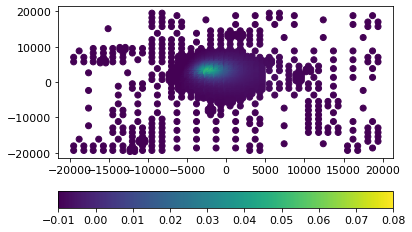

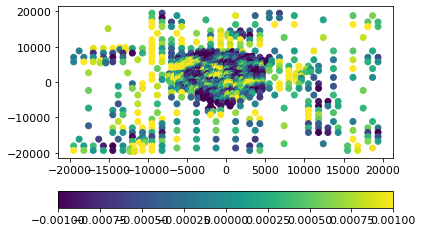

In [20]:
plt.rcParams.update({'font.size': 11})
ansa=np.concatenate((means[0:4],[means[5],means[6]]))
ansd=np.concatenate((means[0:4],[means[5],means[7]]))

print(ansa,ansd)

losma=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losma,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data()-losma,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

losmd=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losmd,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data()-losmd,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

Text(0, 0.5, 'Y(km)')

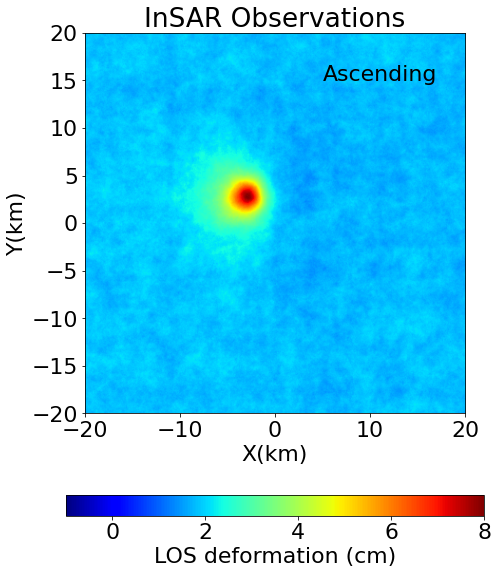

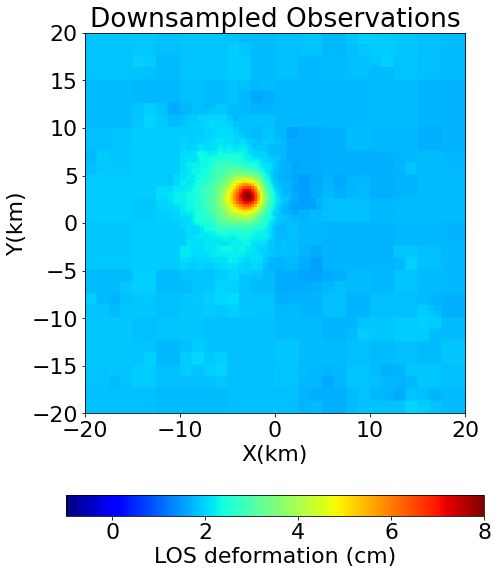

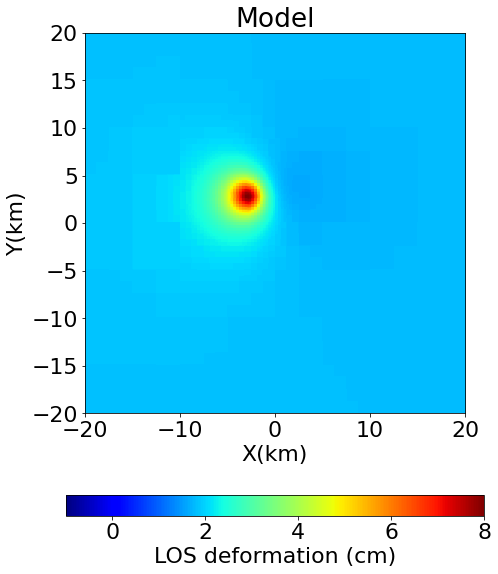

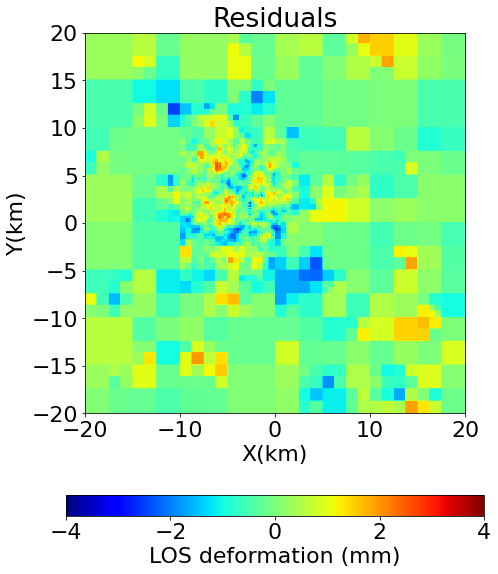

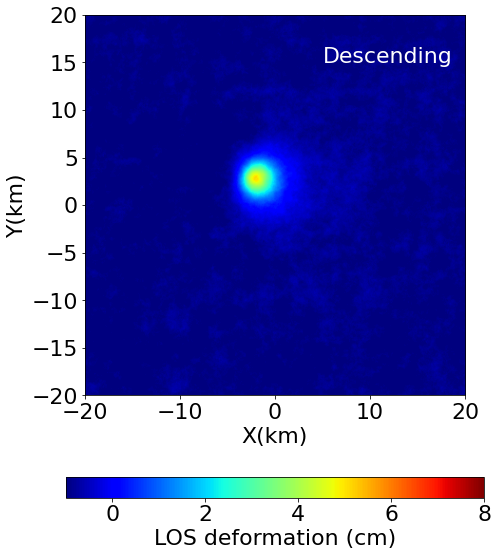

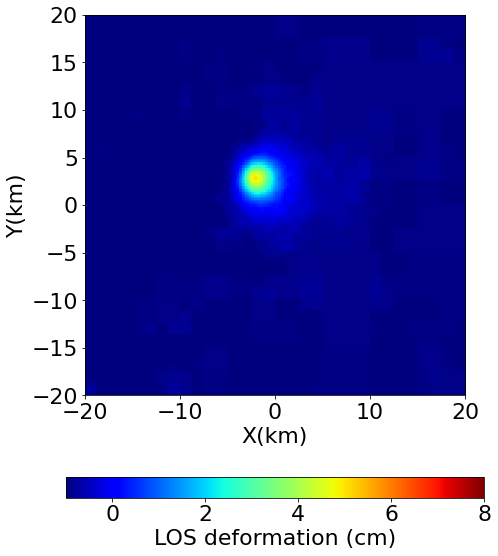

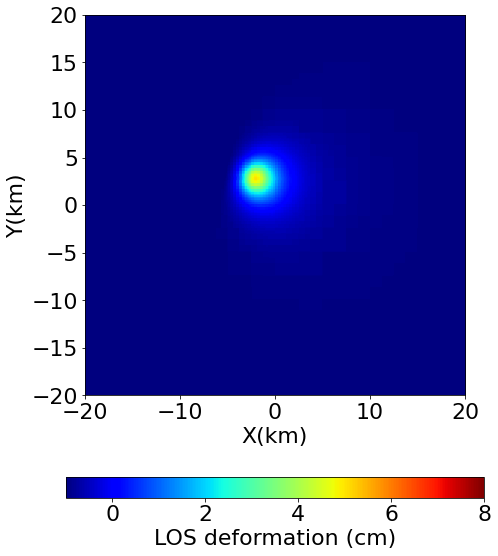

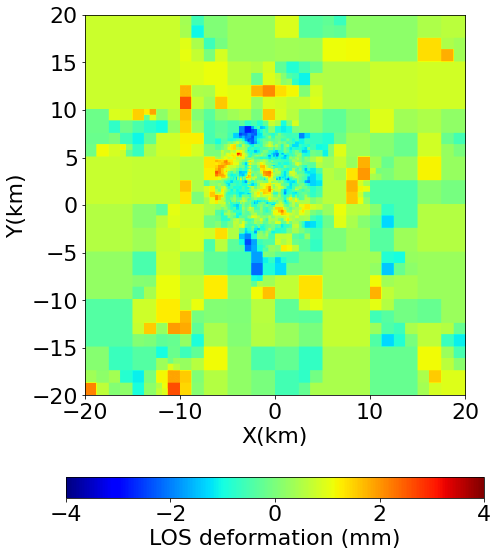

In [38]:
plt.rcParams.update({'font.size': 22})

qmapa,extent=util.los2npy(obsa.get_data(),'examples/dvd/insar/asc_low.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('InSAR Observations')
plt.imshow(losaor*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.text(5,15,s='Ascending')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('Downsampled Observations')
plt.imshow(qmapa*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapma,extent=util.los2npy(losma,'examples/dvd/insar/asc_low.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('Model')
plt.imshow(qmapma*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('Residuals')
plt.imshow((qmapa-qmapma)*1e3,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (mm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapd,extent=util.los2npy(obsd.get_data(),'examples/dvd/insar/des_low.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Observations')
plt.imshow(losdor*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.text(5,15,s='Descending',c='white')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Downsampled observations')
plt.imshow(qmapd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapmd,extent=util.los2npy(losmd,'examples/dvd/insar/des_low.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Model')
plt.imshow(qmapmd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Residuals')
plt.imshow((qmapd-qmapmd)*1e3,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (mm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')